# Tuning Book for NREL 5MW Turbine

### Introduction notes

In [ ]:
# This book presents an example of tuning a FLORIS model to SOWFA data of a turbine operating in various conditions
# For information about the provided data sets see the also provided noteboooks:
#   reviewPowerData.ipynb
#   showWakeProfilesFromSOWFA.ipynb

In [1]:
# Basic module imports
%matplotlib inline
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import cPickle as pickle
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
# Imports from openmdao
from openmdao.api import Problem, Group, IndepVarComp
from pyoptsparse import Optimization, OPT, SNOPT


In [3]:
# Imports from FLORIS
from florisse.floris import DirectionGroup
from florisse import config

In [17]:
#QUESTIONS FOR JARED
###
# 1) What is the purpose of the global variables?
# 2) Why use smooth versus flat
# 3) Where is eta?
# 4) Do I understand what the rotor flag is doing?
###

In [4]:
# Load the SOWFA data sets
yawPos,avPowersYaw, yawPosI2,avPowersYawI2 = pickle.load( open( os.path.join('data','yawPower.p'), "rb" ) )
spacing,avPowersSpace = pickle.load( open( os.path.join('data','spacePower.p'), "rb" ) )
offset4D,avPowersOffset4D = pickle.load( open( os.path.join('data','offset4DPower.p'), "rb" ) )
offset6D,avPowersOffset6D = pickle.load( open( os.path.join('data','offset6DPower.p'), "rb" ) )

### Initial FLORIS Settings

In [5]:
# These initial settings are taken from 
# Gebraad, P. M. O., Teeuwisse, F. W., van Wingerden, J. W., Fleming, P. a., Ruben, S. D., Marden, J. R., & Pao, L. Y. (2014). Wind plant power optimization through yaw control using a parametric model 
#    for wake effects-a CFD simulation study. Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1822
# Which were arrived at through manual tuning and adjustment to SOWFA data selected from
# Fleming, P. A., Gebraad, P. M. O., Lee, S., van Wingerden, J.-W., Johnson, K. E., Churchfield, M., … Moriarty, P. J. (2014). Simulation comparison of wake mitigation control strategies for a two-turbine case. 
#    Wind Energy, n/a–n/a. http://doi.org/10.1002/we.1810

In [6]:
## First select the overal FLORIS simulation parameters
# Maybe some information about all this can go here, 
# Is this general?

model = 'smooth'  # options: 'original', 'smooth'
gradients = 'fd'    # options: 'fd', 'exact'
flat = True        # if False, will use cosine smoothing factor
rotor = True       # if True, will use rotor coupled data
tune = False        # if True, will optimize parameters starting with provided values

if model == 'smooth':
    differentiable = True
else:
    differentiable = False


In [7]:
## Set models for FLORIS parameters
# These are the simulation parameters specific to a given turbine / enviornment

# power
pP = 1.88   # control Cp adjustment to yaw

# deflection
kd = 0.15                       # adjust yaw deflection
# global initialWakeDisplacement
initialWakeDisplacement = -4.5  # initial rotational displacement
bd = -0.01                      # continued deflection from rotation as separation increases
# initialWakeAngle = 0.5*3.0
initialWakeAngle = 1.5

# expansion
ke = 0.065                          # adjust overall rate of wake expansion
# global me
me = np.array([-0.5, 0.22, 1.0])    # adjust individual wake expansion

# velocity
#global MU
MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate

aU = 5.0                            # offset in decay adjustment
bU = 1.66                           # parameter of yaw on decay adjustment
cos_spread = 1e12                   # additional deficit based on crosswind relative location

if rotor:
    # deflection
    kd = 0.17                   # adjust yaw deflection

    # expansion
    ke = 0.05                   # adjust overall rate of wake expansion

    # velocity
    aU = 12.                    # offset in decay adjustment
    bU = 1.3                    # parameter of yaw on decay adjustment

if not flat:
    # velocity
    cos_spread = 2.0                    # additional deficit based on crosswind relative location
    MU = np.array([0.5, 1.0, 5.5])      # zone velocity deficit decay rate
    me = np.array([-0.5, 0.3, 1.0])    # adjust individual wake expansion
    initialWakeAngle = 1.5

In [8]:
# Load the Cp table for NREL 5MW
NREL5MWCPCT = pickle.load(open('../NREL5MWCPCT_smooth_dict.p'))
datasize = NREL5MWCPCT['CP'].size
# These are arrays of CP and CT versus wind speed
NREL5MWCPCT

{'CP': array([ 0.        ,  0.15643578,  0.31287155,  0.41306749,  0.44895632,
         0.46155227,  0.46330747,  0.46316077,  0.46316077,  0.46280642,
         0.45223111,  0.39353012,  0.3424487 ,  0.2979978 ,  0.25931677,
         0.22565665,  0.19636572,  0.17087684,  0.1486965 ,  0.12939524,
         0.11259934,  0.0979836 ,  0.08526502,  0.07419736,  0.06456631,
         0.05618541,  0.04889237,  0.        ]),
 'CT': array([ 1.10610965,  1.09515807,  1.0227122 ,  0.9196487 ,  0.8519047 ,
         0.80328229,  0.76675469,  0.76209299,  0.76209299,  0.75083241,
         0.67210674,  0.52188504,  0.43178758,  0.36443258,  0.31049874,
         0.26696686,  0.22986909,  0.19961578,  0.17286245,  0.15081457,
         0.13146666,  0.11475968,  0.10129584,  0.0880188 ,  0.07746819,
         0.06878621,  0.05977061,  0.        ]),
 'wind_speed': array([  0.        ,   2.5       ,   3.52338654,   4.57015961,
          5.61693268,   6.66370575,   7.71047882,   8.75725189,
          9.804024

In [9]:
# initialize input variable arrays
nTurbines = 2
rotorDiameter = np.zeros(nTurbines)
axialInduction = np.zeros(nTurbines)
Ct = np.zeros(nTurbines)
Cp = np.zeros(nTurbines)
generatorEfficiency = np.zeros(nTurbines)
yaw = np.zeros(nTurbines)


In [10]:
# define initial values
for turbI in range(0, nTurbines):
    rotorDiameter[turbI] = 126.4            # m
    axialInduction[turbI] = 1.0/3.0
    Ct[turbI] = 4.0*axialInduction[turbI]*(1.0-axialInduction[turbI])
    Cp[turbI] = (0.7737/0.944) * 4.0 * 1.0/3.0 * np.power((1. - 1.0/3.0), 2)
    generatorEfficiency[turbI] = 0.944
    yaw[turbI] = 0.     # deg.
print "initial Cp", Cp
print "initial Ct", Ct


initial Cp [ 0.48568738  0.48568738]
initial Ct [ 0.88888889  0.88888889]


In [53]:
# Define a power comparison plotting function
def ComparePower(xPoints,sowfaPower,FLORISpower,xlabel=''):

    fig, axarr = plt.subplots(3,2,figsize=(10,8),sharex=True)

    # Plot turbine 0
    ax = axarr[0,0]
    ax.plot(xPoints,sowfaPower[:,0]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,0],'o-',label='FLORIS')
    ax.set_title('Turbine 0')
    ax.legend()

    ax = axarr[0,1]
    ax.plot(xPoints,100 * (FLORISpower[:,0] - sowfaPower[:,0]/1000.)/(sowfaPower[:,0]/1000.),'x--',label='SOWFA')
    ax.set_title('Turbine 0 % Error')

    # Plot turbine 1
    ax = axarr[1,0]
    ax.plot(xPoints,sowfaPower[:,1]/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,FLORISpower[:,1],'o-',label='FLORIS')
    ax.set_title('Turbine 1')
    ax.legend()

    ax = axarr[1,1]
    ax.plot(xPoints,100 * (FLORISpower[:,1] - sowfaPower[:,1]/1000.)/(sowfaPower[:,1]/1000.),'x--',label='SOWFA')
    ax.set_title('Turbine 1 % Error')

    # Plot total power
    ax = axarr[2,0]
    totalSOWFA = np.sum(sowfaPower,axis=1)
    totalFLORIS = np.sum(FLORISpower,axis=1)
    ax.plot(xPoints,totalSOWFA/1000.,'x--',label='SOWFA')
    ax.plot(xPoints,totalFLORIS,'o-',label='FLORIS')
    ax.set_title('Total')
    ax.set_xlabel(xlabel)
    ax.legend()

    ax = axarr[2,1]
    ax.plot(xPoints,100 * (totalFLORIS - totalSOWFA/1000.)/(totalSOWFA/1000.),'x--',label='SOWFA')
    ax.set_title('Total % Error')
    ax.set_xlabel(xlabel)

### Comparison to ICOWES 2 data sets

In [55]:
# Inflow conditions
wind_speed = 8.1
air_density = 1.1716 
wind_direction = 270.-0.523599*180./np.pi 
wind_direction

239.9999871427296

In [56]:
# Definte the FLORIS model within openmdao

global prob
prob = Problem(root=Group())
# Add a FLORIS model
prob.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])
# set up problem
prob.setup(check=False)

{}

In [57]:
# Add Cp-Ct information
if rotor:
    prob['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    prob['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    prob['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    prob['floris_params:useWakeAngle'] = True
    prob['floris_params:adjustInitialWakeDiamToYaw'] = False
    prob['floris_params:axialIndProvided'] = False
    prob['floris_params:useaUbU'] = True

In [58]:
# Assign all neccessary FLORIS parameters
prob['gen_params:pP'] = pP
prob['floris_params:kd'] = kd
prob['floris_params:initialWakeAngle'] = initialWakeAngle
prob['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
prob['floris_params:bd'] = bd
prob['floris_params:ke'] = ke
prob['floris_params:me'] = me
prob['floris_params:MU'] = MU
prob['floris_params:aU'] = aU
prob['floris_params:bU'] = bU
prob['floris_params:cos_spread'] = cos_spread
prob['rotorDiameter'] = rotorDiameter
prob['axialInduction'] = axialInduction
prob['generatorEfficiency'] = generatorEfficiency
prob['wind_speed'] = wind_speed
prob['air_density'] = air_density
prob['wind_direction'] = wind_direction

In [59]:
prob['turbineX'] = np.array([1118.1, 1881.9])
prob['turbineY'] = np.array([1279.5, 1720.5])
FLORISpower = list()
for yaw1 in yawPosI2:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

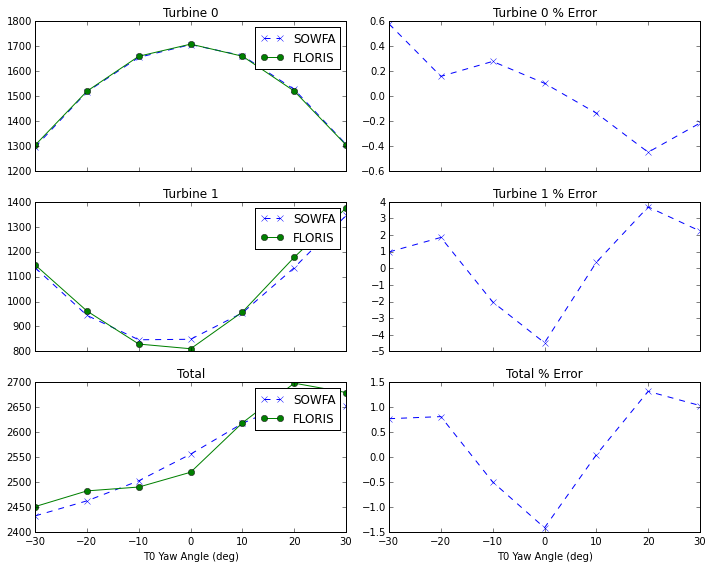

In [60]:
# Compare the power for this case
ComparePower(yawPosI2,avPowersYawI2,FLORISpower,'T0 Yaw Angle (deg)')

### Compare to 4D yaw powers

In [62]:
# Set the turbine positions
prob['turbineX'] = np.array([1118.1, 1556.0])
prob['turbineY'] = np.array([1279.5, 1532.3])
FLORISpower = list()
for yaw1 in yawPos:
    prob['yaw0'] = np.array([yaw1, 0.0])
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

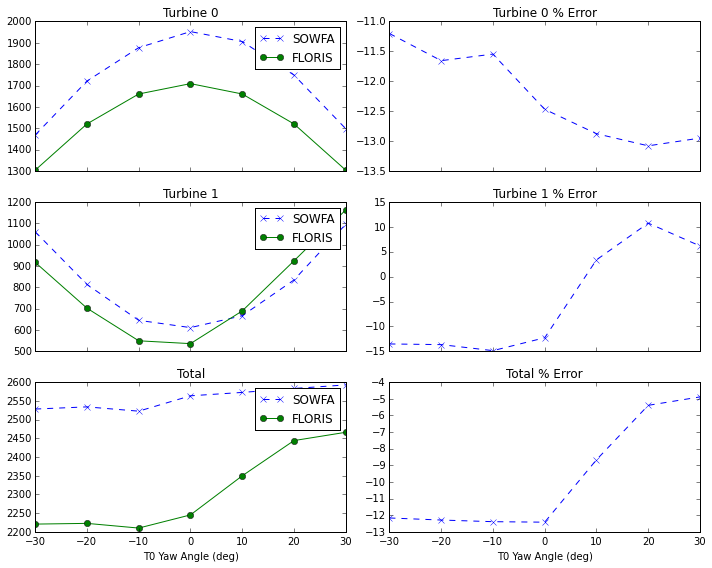

In [63]:
# Compare the power for this case
ComparePower(yawPos,avPowersYaw,FLORISpower,'T0 Yaw Angle (deg)')

### Compare spacing power

In [ ]:
# Compare the powers as the downstream turbine is located at various spacings

In [65]:
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1337.0,1556.0,1774.9,1993.8,2212.7]
turb1_y = [1405.9,1532.3,1658.7,1785.1,1911.5]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(spacing)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

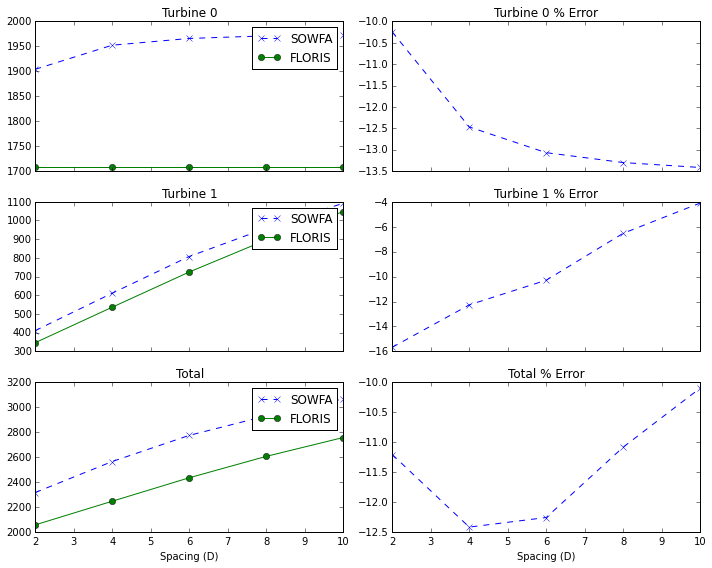

In [66]:
# Compare the power for this case
ComparePower(spacing,avPowersSpace,FLORISpower,'Spacing (D)')

### Compare crosswind locations (4D)

In [67]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1526.0,1541.0,1556.0,1571.0,1586.0]
turb1_y = [1584.3,1558.3,1532.3,1506.3,1480.3]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(offset4D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

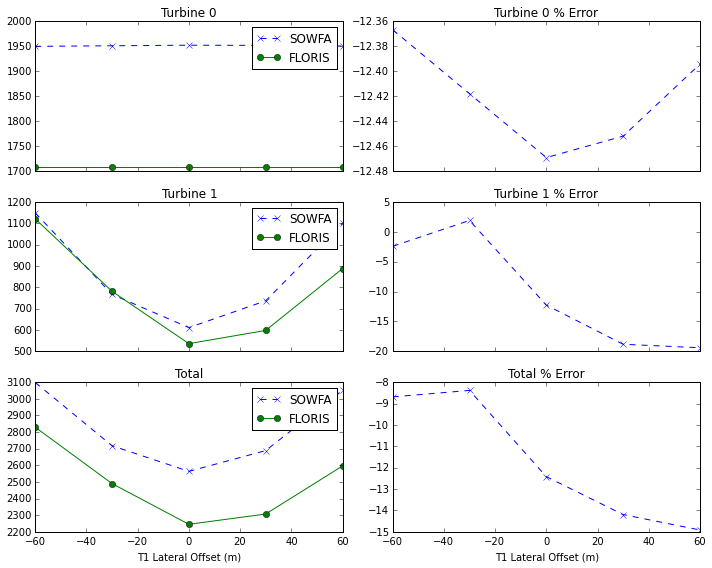

In [68]:
# Compare the power for this case
ComparePower(offset4D,avPowersOffset4D,FLORISpower,'T1 Lateral Offset (m)')

### Compare crosswind locations (6D)

In [69]:
# In this case, the downwind turbine is relocated cross-wind to investigate behavior of partial wake overlap conditions
# Set up the domain for this case where turb0 is fixed, but turbine 2 is moved downstream
turb0_x = 1118.1
turb0_y = 1279.5

turb1_x = [1744.9,1759.9,1774.9,1789.9,1804.9]
turb1_y = [1710.7,1684.7,1658.7,1632.7,1606.7]

FLORISpower = list()

# Reset yaw
prob['yaw0'] = np.array([0.0, 0.0])
for sIDX in range(len(offset6D)):   

    prob['turbineX'] = np.array([turb0_x, turb1_x[sIDX]])
    prob['turbineY'] = np.array([turb0_y, turb1_y[sIDX]])   
    prob.run()
    FLORISpower.append(list(prob['wtPower0']))
    time.sleep(0.001)
FLORISpower = np.array(FLORISpower)

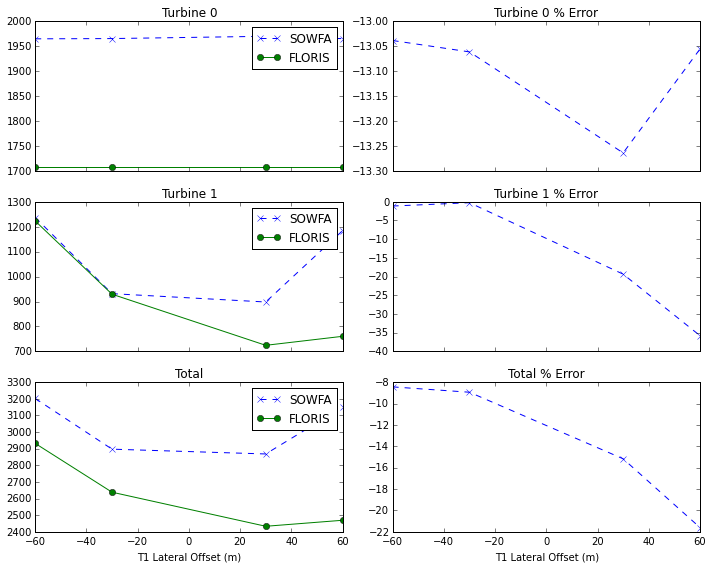

In [70]:
# Compare the power for this case
ComparePower(offset6D,avPowersOffset6D,FLORISpower,'T1 Lateral Offset (m)')

## Compare 1 Turbine wake profiles

In [72]:
# Also available are downwind profiles from a single turbine simulation in SOWFA

In [74]:
# Load the downwind profiles
downStreamLocs,ySampling,caseNames,wakeProfiles = pickle.load( open( os.path.join('data','wakeProfiles.p'), "rb" ) )

In [85]:
# Identify local variables
yawAngles = caseNames #angle of turbine in deg
numYaw = len(yawAngles)
numDownStreamLocs = len(downStreamLocs)
numSamples = len(ySampling)

# ySampling gives (in D) a lateral offset from a given downstream location, need to convert this actual FLORIS positons
# assume for now initial turbine at 0, and downwind along x axis


In [ ]:
# Let's redo prob for 1-turbine case
# Inflow conditions
wind_speed = 8.1
air_density = 1.1716 
wind_direction = 270 # Lets go right down x


In [82]:
nTurbines = 1
rotorDiameter = np.zeros(nTurbines)
axialInduction = np.zeros(nTurbines)
Ct = np.zeros(nTurbines)
Cp = np.zeros(nTurbines)
generatorEfficiency = np.zeros(nTurbines)
yaw = np.zeros(nTurbines)
global prob_oneTurb
prob_oneTurb = Problem(root=Group())
# Add a FLORIS model
prob_oneTurb.root.add('FLORIS', DirectionGroup(nTurbines, use_rotor_components=rotor,
                                           datasize=datasize, differentiable=differentiable), promotes=['*'])
# set up problem
prob_oneTurb.setup(check=False)

# define initial values
for turbI in range(0, nTurbines):
    rotorDiameter[turbI] = 126.4            # m
    axialInduction[turbI] = 1.0/3.0
    Ct[turbI] = 4.0*axialInduction[turbI]*(1.0-axialInduction[turbI])
    Cp[turbI] = (0.7737/0.944) * 4.0 * 1.0/3.0 * np.power((1. - 1.0/3.0), 2)
    generatorEfficiency[turbI] = 0.944
    yaw[turbI] = 0.     # deg.
print "initial Cp", Cp
print "initial Ct", Ct


initial Cp [ 0.48568738]
initial Ct [ 0.88888889]


In [83]:
# Add Cp-Ct information
if rotor:
    prob_oneTurb['gen_params:windSpeedToCPCT_CP'] = NREL5MWCPCT['CP']
    prob_oneTurb['gen_params:windSpeedToCPCT_CT'] = NREL5MWCPCT['CT']
    prob_oneTurb['gen_params:windSpeedToCPCT_wind_speed'] = NREL5MWCPCT['wind_speed']
    prob_oneTurb['floris_params:useWakeAngle'] = True
    prob_oneTurb['floris_params:adjustInitialWakeDiamToYaw'] = False
    prob_oneTurb['floris_params:axialIndProvided'] = False
    prob_oneTurb['floris_params:useaUbU'] = True
    # Assign all neccessary FLORIS parameters
prob_oneTurb['gen_params:pP'] = pP
prob_oneTurb['floris_params:kd'] = kd
prob_oneTurb['floris_params:initialWakeAngle'] = initialWakeAngle
prob_oneTurb['floris_params:initialWakeDisplacement'] = initialWakeDisplacement
prob_oneTurb['floris_params:bd'] = bd
prob_oneTurb['floris_params:ke'] = ke
prob_oneTurb['floris_params:me'] = me
prob_oneTurb['floris_params:MU'] = MU
prob_oneTurb['floris_params:aU'] = aU
prob_oneTurb['floris_params:bU'] = bU
prob_oneTurb['floris_params:cos_spread'] = cos_spread
prob_oneTurb['rotorDiameter'] = rotorDiameter
prob_oneTurb['axialInduction'] = axialInduction
prob_oneTurb['generatorEfficiency'] = generatorEfficiency
prob_oneTurb['wind_speed'] = wind_speed
prob_oneTurb['air_density'] = air_density
prob_oneTurb['wind_direction'] = wind_direction

In [84]:
# Put a signle turbine at 0
turb0_x = 0.0
turb0_y = 0.0

In [86]:
# Now run a loop to probe
florisSample = np.zeros(numSamples,numDownStreamLocs)
for s in range(numSamples):
    for d in range(numDownStreamLocs):
        prob['turbineX'] = np.array([turb0_x, downStreamLocs[d] * rotorDiameter[0]])
        prob['turbineY'] = np.array([turb0_y, ySampling[s]])
        prob_oneTurb.run()
        florisSample[s,d] = prob_oneTurb['wtVelocity0']

TypeError: data type not understood